# 158.739 Assignment 4
#### By Christina Xie 20008709

## 1. Introduction
Auckland's real estate market has been astounding concerning property price. The study aims to provide an insight into the current market and analyse how different features of a property can affect its sale price. This study is based on property listings in the Auckland region. The primary data is acquired from the website of Realestate.co.nz Ltd. by web-scraping, with the integration of latitudes and longitudes of each property using MapQuest Geocoding API.

The subsequent sections are arranged as follows. In section 2, the process of data acquisition and integration is shown. It is followed by the data wrangling procedure in section3 that includes data cleaning, missing values handling, and adding any other valuable variables. In section 4, I perform a set of visualisations on the median sale price of properties concerning different suburbs, areas, number of rooms, and property types. The report is finished with a summary of key findings.

## 2. Data Acquisition and Integration

First of all, I install some essential modules that are the dependencies for using GeoPandas. I then install the GeoPandas to plot the latittues and longitudes on a map. 

In [7]:
pip install GDAL-3.2.3-cp38-cp38-win_amd64.whl

Processing c:\users\64212\158.739 intro to analytics\assignment 3&4\gdal-3.2.3-cp38-cp38-win_amd64.whl
  Attempting uninstall: GDAL
    Found existing installation: gdal 3.3.0
    Uninstalling gdal-3.3.0:
      Successfully uninstalled gdal-3.3.0
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install Fiona-1.8.19-cp38-cp38-win_amd64.whl

Processing c:\users\64212\158.739 intro to analytics\assignment 3&4\fiona-1.8.19-cp38-cp38-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install pyproj-3.1.0-cp38-cp38-win_amd64.whl

Processing c:\users\64212\158.739 intro to analytics\assignment 3&4\pyproj-3.1.0-cp38-cp38-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install Shapely-1.7.1-cp38-cp38-win_amd64.whl

Processing c:\users\64212\158.739 intro to analytics\assignment 3&4\shapely-1.7.1-cp38-cp38-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: matplotlib in c:\users\64212\anaconda3\lib\site-packages (from descartes) (3.2.2)



In [1]:
pip install geopandas

  Using cached geopandas-0.9.0-py2.py3-none-any.whl (994 kB)
Note: you may need to restart the kernel to use updated packages.


In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import json
import pprint as pp

# import libraries that support map plotting
import descartes
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

import pylab
from pylab import rcParams
rcParams['figure.dpi'] = 400
rcParams['lines.linewidth'] = 2 

sns.set_context("notebook", font_scale=1.2)
sns.set_style("darkgrid")

%matplotlib inline

### 2.1 Get Auckland property listings by web-scraping

To access the webpage successfully, I want to check if I get the 200 status code. However, I received a response code 403, suggesting that the server forbids my request. A possible reason could be not specifying a valid header. A header contains the information of a request, such as the language of response and type of data. The server can recognise and respond when it detects such information. Therefore, I provide a "User-agent" header that acts like my ID, specifically my software's ID. In this way, I have sufficient access to the webpage. 

In [3]:
# check status code
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36'}
url = "https://www.realestate.co.nz/residential/sale/auckland?by=latest&oad=true&pm=1"
response = requests.get(url, headers=headers)
response

<Response [200]>

Below is my multiple For Loop statements that scrape every piece of information about a property that I intend to use. I include the location, number of bedrooms and bathrooms, land size, property type, and property price of all properties for sale. I also primarily set the page to display address and price because I think they should not be null for subsequent analysis, and the website allows for such settings. 

The whole process starts with specifying when the loops will stop processing. The property listings are dynamic, so I will never know the number of pages that the loop statements should iterate. I found that on the last page, the "next" button disappears. Therefore, I decide to write the ```while True``` statement to let the process stop when there is no "next" button. Other solutions have also been considered, such as specifying the status code when the page is out-of-range. Ideally, it will be 404, yet somehow the status code is still 200.

Furthermore, because multiple requests are made to access multiple URLs by the same server, I use the session object upfront to avoid numerous connections and improve the web-scraping performance. I am also using "lxml" as the HTML parser because it is faster. The subsequent loops are to scrape the information of a property based on the elements of properties on page 1. Finally, I append the lists into a single list and convert it into a pandas dataframe.

In [4]:
listing_details = []

# specify when the loops will stop
page = 0
session = requests.Session()

while True:
    page += 1
    response = session.get('https://www.realestate.co.nz/residential/sale/auckland?by=latest&oad=true&page={}&pm=1'.format(page), headers=headers)
    listings = BeautifulSoup(response.content, "lxml")
    
    next_button = listings.select_one('[data-test=next-link]')   
    
    if next_button is None:
        break    
    
    # all subsequent elements are embedded inside this tag
    details = listings.findAll('div', attrs={"data-test":"tile"})
    for detail in details:

        # get addresses
        addresses = detail.findAll('h3')
        for address in addresses:
            address=address.text.strip()  # remove \n
        
        # get the number of bedrooms and bathrooms and the land size, if available
        icons = detail.findAll('strong', class_=False, id=False)
        if len(icons) == 3:
            for icon in icons:
                bedroom = icons[0].text
                bathroom = icons[1].text
                land_area = icons[2].text
        elif len(icons) == 2:
            for icon in icons:
                bedroom = icons[0].text
                bathroom = icons[1].text
                land_area = np.nan
        else:
            for icon in icons:
                bedroom = np.nan
                bathroom = np.nan
                land_area = icons[0].text

        # get property types
        property_types = detail.findAll('strong', attrs={"class":"truncate leading-normal"})
        for property_type in property_types:
            property_type = property_type.text

        # get property prices
        prices = detail.select("div.text-right.leading-tight")
        for price in prices:
            price = price.text

        # append a list of lists into a single list
        listing_details.append([address, bedroom, bathroom, land_area, property_type, price])

df = pd.DataFrame(listing_details, columns=['Location','Bedroom','Bathroom','LandSize_m2','PropertyType','SalePrice'])
df.head()

,Location,Bedroom,Bathroom,LandSize_m2,PropertyType,SalePrice
0,"17/104 Rosier Road, Glen Eden",2,1,NaN,Townhouse,"$819,000"
1,"35 Hobson Street, Auckland Central",1,1,NaN,Apartment,"$549,000"
2,"158 Onehunga Mall, Onehunga",2,1,88m2,Apartment,"Asking Price $760,000"
3,"8 Ronayne Street, Auckland Central",3,2,NaN,Apartment,"$209,000"
4,"430 Queen Street, Auckland Central",2,1,NaN,Apartment,"$409,000"


### 2.2 Get geocodes using MapQuest Geocoding API

I also want to acquire the geocodes of each property. These will be used for subsequent mapping for better visualisation. The geocoding API I use is from MapQuest (https://developer.mapquest.com/documentation/geocoding-api/address/get/) because they offer a free API key. 

I first check for the status code and test the API by using one address. Next, I extract the JSON object and find the latitude and longitude of this address. While accessing the latitudes and longitudes, I found that the information was correct only when I added the country name. Thus, I create an "apiLocation" which contains the address plus the country name in the loop. 

I again use the session object for performance improvement. I tested the wall time with the magic time function for the situations when using the session object or not, respectively. And I found that the appearance of the session object led to 3 seconds faster in wall time when a loop iterating through the properties on page 1 (not shown in this version of Assignment 4 because I only used the results from page 1 for code testing). Finally, I use a loop statement to get latitudes and longitudes from all addresses.

In [5]:
# check status code

parameters = {
    "key": "AQUOOAew4GGLxM9es8JFAqe1WtNft35W",
    "location": "14 Cotesmore Way, Parnell, New Zealand"
}

url = "http://www.mapquestapi.com/geocoding/v1/address"

res = requests.get(url, params=parameters)

print(res)

<Response [200]>


In [6]:
# extract JSON object

data = json.loads(res.content)
pp.pprint(data)

{'info': {'copyright': {'imageAltText': '© 2021 MapQuest, Inc.',
                        'imageUrl': 'http://api.mqcdn.com/res/mqlogo.gif',
                        'text': '© 2021 MapQuest, Inc.'},
          'messages': [],
          'statuscode': 0},
 'options': {'ignoreLatLngInput': False, 'maxResults': -1, 'thumbMaps': True},
 'results': [{'locations': [{'adminArea1': 'NZ',
                             'adminArea1Type': 'Country',
                             'adminArea3': 'North Island',
                             'adminArea3Type': 'State',
                             'adminArea4': '',
                             'adminArea4Type': 'County',
                             'adminArea5': 'Auckland',
                             'adminArea5Type': 'City',
                             'adminArea6': '',
                             'adminArea6Type': 'Neighborhood',
                             'displayLatLng': {'lat': -36.84886,
                                               'lng': 174.

In [7]:
# get latitudes and longitudes from all the addresses

sess = requests.Session()

for i, row in df.iterrows():
    apiLocation = row['Location'] + ', New Zealand'
    
    parameters = {
    "key": "AQUOOAew4GGLxM9es8JFAqe1WtNft35W",
    "location": apiLocation
}

    res = sess.get(url, params=parameters)
    data = json.loads(res.content)

    lat = data['results'][0]['locations'][0]['latLng']['lat']
    lon =data['results'][0]['locations'][0]['latLng']['lng']

    df.at[i, 'Latitude'] = lat
    df.at[i, 'Longitude'] = lon

In [8]:
df.head()

,Location,Bedroom,Bathroom,LandSize_m2,PropertyType,SalePrice,Latitude,Longitude
0,"17/104 Rosier Road, Glen Eden",2,1,NaN,Townhouse,"$819,000",-36.91808,174.63994
1,"35 Hobson Street, Auckland Central",1,1,NaN,Apartment,"$549,000",-36.84668,174.76202
2,"158 Onehunga Mall, Onehunga",2,1,88m2,Apartment,"Asking Price $760,000",-36.92358,174.78530
3,"8 Ronayne Street, Auckland Central",3,2,NaN,Apartment,"$209,000",-36.84914,174.77488
4,"430 Queen Street, Auckland Central",2,1,NaN,Apartment,"$409,000",-36.85432,174.76324


#### Reference

What is 403 Forbidden response, from https://www.ibm.com/docs/en/spm/6.2.0?topic=apis-403-forbidden-http-status-code-response

What are request headers, from https://365datascience.com/tutorials/python-tutorials/request-headers-web-scraping/

Use ```headers={}``` to solve the problem of status code, from https://stackoverflow.com/questions/48081655/python-web-scrape-403-error

Find elements without class and id attributes, from https://stackoverflow.com/questions/34370521/scraping-elements-without-an-id-or-class-from-a-web-page-using-python-beautifuls

```select()```, from https://stackoverflow.com/questions/38028384/beautifulsoup-difference-between-find-and-select

Append multiple arguments, from https://community.dataquest.io/t/using-the-append-method-with-two-arguments/515619

Loop through multiple pages, from https://stackoverflow.com/questions/46706805/scrape-multiple-pages-with-loops-in-python

```requests.Session()```, from https://docs.python-requests.org/en/master/user/advanced/

```page+=1```, from https://stackoverflow.com/questions/4841436/what-exactly-does-do-in-python

```select_one()```, from https://stackoverflow.com/questions/58321471/how-to-scrape-content-from-a-div-class-based-on-data-automation-attribute-in-pyt

```df.at[index, column_name]```, from https://stackoverflow.com/questions/31458794/python-using-iterrows-to-create-columns

## 3. Data Wrangling

### 3.1 Cleaning and transforming

In [9]:
# display the dataframe information and table to detect problems
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Location      2760 non-null   object 
 1   Bedroom       2368 non-null   object 
 2   Bathroom      2368 non-null   object 
 3   LandSize_m2   1126 non-null   object 
 4   PropertyType  2760 non-null   object 
 5   SalePrice     2760 non-null   object 
 6   Latitude      2760 non-null   float64
 7   Longitude     2760 non-null   float64
dtypes: float64(2), object(6)
memory usage: 172.6+ KB


In [10]:
df.head()

,Location,Bedroom,Bathroom,LandSize_m2,PropertyType,SalePrice,Latitude,Longitude
0,"17/104 Rosier Road, Glen Eden",2,1,NaN,Townhouse,"$819,000",-36.91808,174.63994
1,"35 Hobson Street, Auckland Central",1,1,NaN,Apartment,"$549,000",-36.84668,174.76202
2,"158 Onehunga Mall, Onehunga",2,1,88m2,Apartment,"Asking Price $760,000",-36.92358,174.78530
3,"8 Ronayne Street, Auckland Central",3,2,NaN,Apartment,"$209,000",-36.84914,174.77488
4,"430 Queen Street, Auckland Central",2,1,NaN,Apartment,"$409,000",-36.85432,174.76324


By looking at the information table and pandas dataframe above, I decide to modify three variables as follows:
* The data type of bedroom and bathroom is an object, but they should be an integer type instead. I convert it to float first because NumPy does not allow an object type to become an integer type. The size of an integer is 64 because it allows for nullable values.
* There are two different scales of land size: square meter and hectare. I apply a user-defined function to remove the last two characters and convert the unit into a square meter since it is majorly used.
* The "SalePrice" column has text, dollar signs, and commas within the cells, making it an object type. I remove the unwanted characters and convert the column into the integer type.

In [11]:
# object needs to be converted to float first then convert to Int64 which allows for NaN
df['Bedroom'] = df['Bedroom'].astype(float).astype('Int64')
df['Bathroom'] = df['Bathroom'].astype(float).astype('Int64')


# apply function to convert the scale of land area
def convert_unit(val):
    if str(val).endswith('ha'):
        return float(val[:-2]) * 10000
    elif str(val).endswith('m2'):
        return float(val[:-2]) * 1
    else:
        return np.nan
df['LandSize_m2'] = df[['LandSize_m2']].applymap(convert_unit)


# remove unwanted characters and convert string into integer
df['SalePrice'] = df['SalePrice'].str.replace(',','')
df['SalePrice'] = df['SalePrice'].str.extract(r'(\d+(?:\.\d+)?)').astype(int)

Besides the obvious mistakes on the unusable format, as shown above, some addresses are too long to be fully displayed, and so are they in the dataframe. Since they all end with have an ellipsis, as shown in the images, I remove the addresses having such a pattern. I then reset the index and remove the old index column.

<img src=../figures/long_address.jpg width=900>

<img src=../figures/long_address2.jpg width=900>

In [12]:
df = df.drop(df[df['Location'].str.endswith('...')].index).reset_index()
df = df.drop(['index'], axis=1)

### 3.2 Missing values

As seen in the heatmap in Figure 1, missing values occur in the Bedroom, Bathroom, and LandSize_m2 variables. The frequencies of missing values appearing in the Bedroom and Bathroom columns are identical. There is a large number of missing values in the LandSize_m2 variable. The missing values in these three variables tend to have a pattern of occurrence that a property has values in Bedroom and Bathroom but not in LandSize_m2 and vice versa.

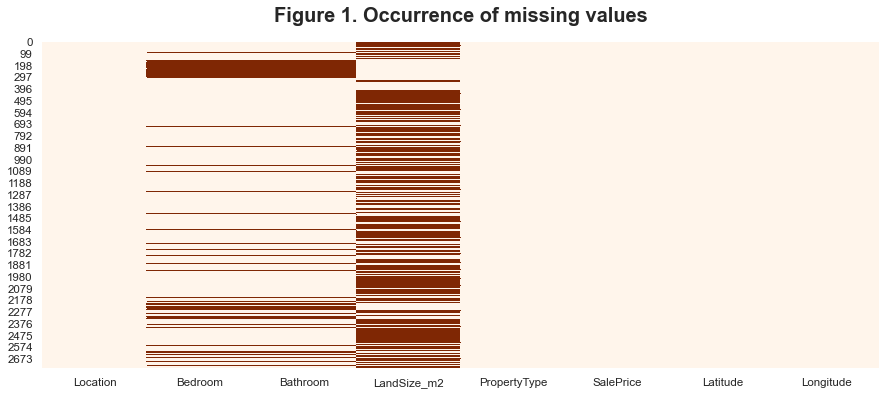

In [13]:
plt.figure(figsize=(15,6))
plt.title('Figure 1. Occurrence of missing values', fontsize=20, fontweight='bold', pad=20)
sns.heatmap(df.isnull(), cbar=False, cmap="Oranges")

Therefore, I first remove the rows with missing values in all three columns because those rows are useless for this study. And since the frequencies of missing values in Bedroom and Bathroom are not very high, missing values are imputed with their modes which are 2 and 1, respectively. Missing values in the LandSize_m2 will not be imputed with any value because it is meaningless when the null value is the mode or mean.

In [14]:
df = df.dropna(thresh=2)

In [15]:
mode_bed = df['Bedroom'].mode()[0]
mode_bath = df['Bathroom'].mode()[0]

print('Mode of Bedroom variable:', mode_bed)
print('Mode of Bathroom variable', mode_bath)

Mode of Bedroom variable: 2
Mode of Bathroom variable 1


In [16]:
df['Bedroom'] = df['Bedroom'].fillna(mode_bed)
df['Bathroom'] = df['Bathroom'].fillna(mode_bed)

### 3.3 Adding more variables

In [17]:
df.head()

,Location,Bedroom,Bathroom,LandSize_m2,PropertyType,SalePrice,Latitude,Longitude
0,"17/104 Rosier Road, Glen Eden",2,1,NaN,Townhouse,819000,-36.91808,174.63994
1,"35 Hobson Street, Auckland Central",1,1,NaN,Apartment,549000,-36.84668,174.76202
2,"158 Onehunga Mall, Onehunga",2,1,88.0,Apartment,760000,-36.92358,174.78530
3,"8 Ronayne Street, Auckland Central",3,2,NaN,Apartment,209000,-36.84914,174.77488
4,"430 Queen Street, Auckland Central",2,1,NaN,Apartment,409000,-36.85432,174.76324


I want to extract the suburb from each address. As you can see from the pandas dataframe above, addresses are ended with the corresponding suburbs separated by a comma. Therefore, I extract the suburbs using a splitting method and create a new column called "Suburb".

In [18]:
# get suburbs

df['Suburb'] = df['Location'].str.rsplit(", ").str[-1]

Based on the locations of suburbs, I further group them into five different groups in the "Area" column. The areas include West, East, NorthShore, Central, and Other. The grouping is based on the information from the wards under Auckland Council and from Te Ara Encyclopedia of New Zealand. "Other" area includes properties on islands and those in other urban suburbs including Rodney, Papakura, Franklin, and so on.

In [19]:
# get areas

West = ['Anawhata', 'Bethells Beach', 'Glen Eden', 'Glendene', 'Green Bay', 'Henderson', 'Herald Island', 'Hobsonville', 
        'Huia', 'Karekare', 'Kelston', 'Konini', 'Kumeu', 'Laingholm', 'Lincoln', 'McLaren Park', 'Massey', 'New Lynn', 
        'Oratia', 'Piha', 'Ranui', 'Royal Heights', 'Sunnyvale', 'Swanson', 'Te Atatu', 'Te Atatu Peninsula', 
        'Te Atatu South', 'Titirangi', 'Waiatarua', 'Westgate', 'West Harbour', 'Western Heights', 'Whenuapai']

East = ['Howick', 'Pakuranga', 'Pakuranga Heights', 'Half Moon Bay', 'Botany Downs', 'Dannemora', 'Ormiston', 
        'Highland Park', 'Bucklands Beach', 'East Tamaki', 'Botany', 'Cockle bay', 'Sunnyhills', 'Somerville', 
        'Burswood', 'Eastern Beach', 'Farm Cove', 'Shelly Park', 'Mellons Bay', 'Golflands', 'Northpark', 
        'Shamrock Park', 'Huntington Park', 'Highbrook', 'East Tamaki Heights']

NorthShore = ['Orewa', 'Greenhithe', 'Pinehill', 'Browns Bay', 'Albany', 'Albany Heights', 'Fairview Heights', 
              'Lucas Heights', 'Oteha', 'Paremoremo', 'Rosedale', 'Schnapper Rock', 'Unsworth Heights', 'Windsor Park', 
              'North Harbour',  'Long Bay', 'Mairangi Bay', 'Murrays Bay', 'Northcross', 'Okura', 'Rothesay Bay', 
              'Torbay', 'Waiake', 'Beach Haven', 'Birkdale', 'Birkenhead', 'Chatswood', 'Northcote', 'Northcote Point', 
              'Highbury', 'Bayview', 'Glenfield', 'Hillcrest', 'Wairau Valley', 'Bayswater', 'Belmont', 'Devonport', 
              'Narrow Neck', 'Stanley Bay', 'Stanley Point', 'Totara Vale', 'Westlake', 'Campbells Bay', 'Castor Bay', 
              'Forrest Hill', 'Hauraki', 'Milford', 'Sunnynook', 'Takapuna']

Central = ['Orakei', 'Mission Bay', 'Kohimarama', 'Saint Heliers', 'Glendowie', 'Saint Johns', 'Stonefields', 'Meadowbank', 
           'Glen Innes', 'Point England', 'Panmure', 'Mount Wellington', 'Auckland Central', 'Eden Terrace', 
           'Ellerslie', 'Epsom', 'Freemans Bay', 'Grafton', 'Greenlane', 'Grey Lynn', 'Herne Bay', 'Newmarket', 
           'Mission Bay', 'Newton', 'One Tree Hill', 'Parnell', 'Ponsonby', 'Remuera', 'Saint Marys Bay', 
           'Wynyard Quarter', 'Balmoral', 'Mount Roskill', 'Morningside', 'Mount Eden', 'Sandringham', 'Three Kings', 
           'Waiotaiki Bay', 'Mount Albert', 'Point Chevalier', 'Western Springs', 'Avondale', 'Mount Roskill', 'Lynfield', 
           'Hillsborough', 'Owairaka', 'New Windsor', 'Waterview', 'Westmere', 'Onehunga', 'Tamaki', 'Blockhouse Bay', 
           'Lynfield', 'Penrose', 'Royal Oak']

South = ['Otahuhu', 'Flat Bush', 'Mission Heights', 'Alfriston', 'Auckland Airport', 'Brookby', 'Clendon Park', 'Clevedon', 
         'Clover Park', 'Favona', 'Whitford', 'Manurewa', 'Manurewa East', 'Wiri', 'Otara', 'Manukau', 'Papatoetoe', 'Mangere', 
         'Mangere East', 'Mangere Bridge', 'Ihumatao', 'Goodwood Heights', 'Weymouth', 'Conifer Grove', 'Manukau Heights', 
         'Manukau Central', 'Maraetai', 'Beachlands', 'Ness Valley', 'The Gardens', 'Totara Heights', 'Totara Park', 
         'Wattle Downs', 'Orere Point']


area = []

for row in df['Suburb']:
    if row in West:
        area.append('West')
    elif row in East:
        area.append('East')
    elif row in NorthShore:
        area.append('NorthShore')
    elif row in Central:
        area.append('Central')
    elif row in South:
        area.append('South')
    else:
        area.append('Other')

df['Area'] = area


# resort the order of columns
df = df.reindex(columns=['Location','Suburb','Area','Bedroom','Bathroom','LandSize_m2',
                         'PropertyType','SalePrice','Latitude','Longitude'])

Based on the latitudes and longitudes acquired, I transform them into points using the shapely object. I then create a GeoDataframe with the points so that addresses can be graphed on a map.

In [345]:
# specify coordinate reference system
crs = {'init':'EPSG:4326'}

# read latitudes and longitudes into points
geometry = gpd.points_from_xy(df['Longitude'], df['Latitude'])

# convert the results into geopandas dataframe
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

C:\Users\64212\anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Finally, I persist the dataset in a csv form.

In [349]:
df.to_csv('../datasets/akl_property_listings.csv', index=False)

#### Reference

Convert ```object``` to ```float``` first, from https://stackoverflow.com/questions/47333227/pandas-valueerror-cannot-convert-float-nan-to-integer

Convert ```object``` to ```Int64```, from https://stackoverflow.com/questions/39690742/convert-float-to-int-and-leave-nulls

```endswith()```, from https://www.programiz.com/python-programming/methods/string/endswith

```rsplit()```, from https://stackoverflow.com/questions/49660209/extract-last-term-after-comma-into-new-column

All wards under Auckland Council, from https://www.aucklandcouncil.govt.nz/about-auckland-council/how-auckland-council-works/governing-body-wards-committees/wards/all-wards/Pages/default.aspx

Te Ara Encyclopedia of New Zealand, https://teara.govt.nz/en

Create a GeoDataframe, from https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

## 4. Analysis and Visualisation

In [438]:
# display the dataframe to remind me of what my dataset looks like
df.head(3)

,Location,Suburb,Area,Bedroom,Bathroom,LandSize_m2,PropertyType,SalePrice,Latitude,Longitude,geometry
0,"17/104 Rosier Road, Glen Eden",Glen Eden,West,2,1,NaN,Townhouse,819000,-36.91808,174.63994,POINT (174.63994 -36.91808)
1,"35 Hobson Street, Auckland Central",Auckland Central,Central,1,1,NaN,Apartment,549000,-36.84668,174.76202,POINT (174.76202 -36.84668)
2,"158 Onehunga Mall, Onehunga",Onehunga,Central,2,1,88.0,Apartment,760000,-36.92358,174.78530,POINT (174.78530 -36.92358)


I want to analyse the median price instead of the average price because the average price is sensitive to outliers. In other words, properties with far more or far lower sale prices than most of the properties will skew the results, which will not represent the housing market very well.

As can be seen from the table below, the median sale price is $\$$829,500 in Auckland.

In [350]:
df[['SalePrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,2752.0,1.178131e+06,2.477624e+06,55000.0,559000.0,829500.0,1295000.0,50000000.0


### 4.1 Overview of the sale price of Auckland properties

To view the property sale price and unit price in Auckland in general, I plot the sale price and unit price of all addresses respectively on maps using the GeoPandas library. First, I read in an Auckland region shapefile as my base map sourced from Data.govt.nz. I then set the boundaries of maps by referring to the information on the NZ Transport Agency. For better visualisation, I specify the quantitles of the price and differentiate them by using different colours.

From Figure 2 we can see that generally, the further north, the higher the sale price, regardless of the property type, room features, and land size. This is especially true for those in southern Auckland. However, some properties situated in the northwest of Auckland also have a higher sale price. This might be due to the larger land size because these properties are in rural areas. Moreover, the more the properties are closed to the center of Auckland, the higher the sale price. Coastal properties are also more expensive than inland properties.

(-37.45, -36.1)

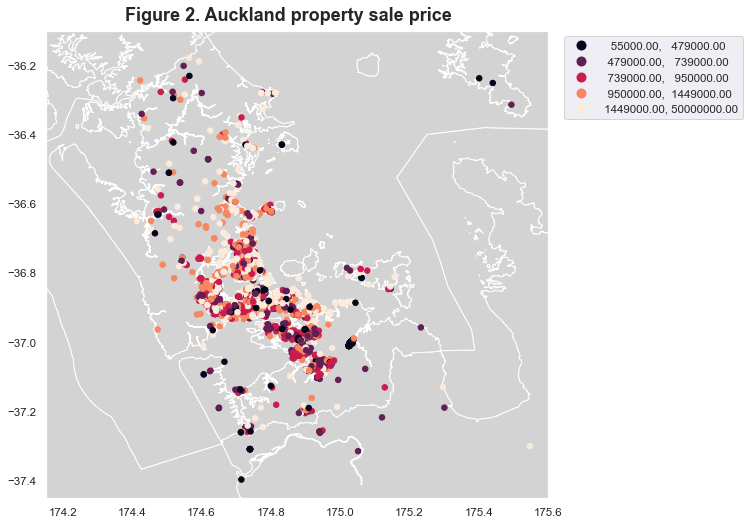

In [244]:
# read Auckland shape file
akl_map = gpd.read_file('../assignment 3&4/Base_Region-shp/BaseRegionAucklandCouncil.shp')

fig, ax = plt.subplots(figsize=(9,9))
fig.suptitle('Figure 2. Auckland property sale price', fontsize=18, fontweight='bold', y=0.9)

akl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column='SalePrice', ax=ax, legend=True, scheme='quantiles', legend_kwds={'bbox_to_anchor': (1.4, 1)}, markersize=30, cmap='rocket')

# set boundaries
plt.xlim(174.15, 175.6)
plt.ylim(-37.45, -36.1)

### 4.2 Area and suburb features

### 4.2.1 Popular areas and suburbs in the market

Figure 4 shows the number of properties in each area and each suburb in the Auckland Region. The most popular areas are Central Auckland and Other. The number of properties for sale is distinctly high in Auckland Central and Papakura. Papakura belongs to the "Other" area group, so the number of properties in "Other" is also high.

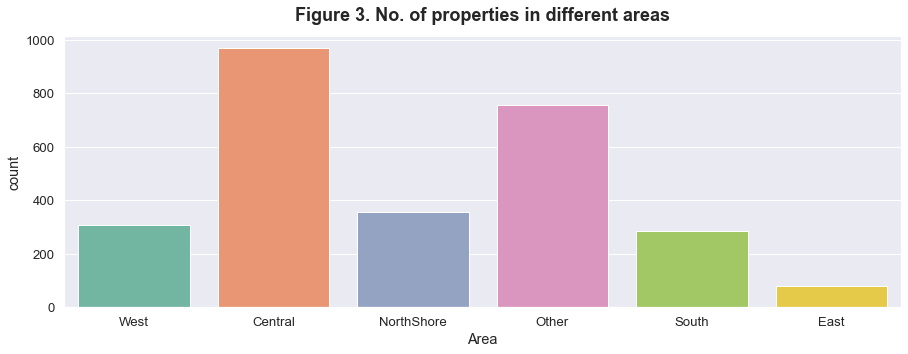

In [392]:
plt.figure(figsize=(15,5))
plt.title('Figure 3. No. of properties in different areas', fontsize=18, fontweight='bold', pad=15)
sns.countplot(data=df, x='Area', palette='Set2')

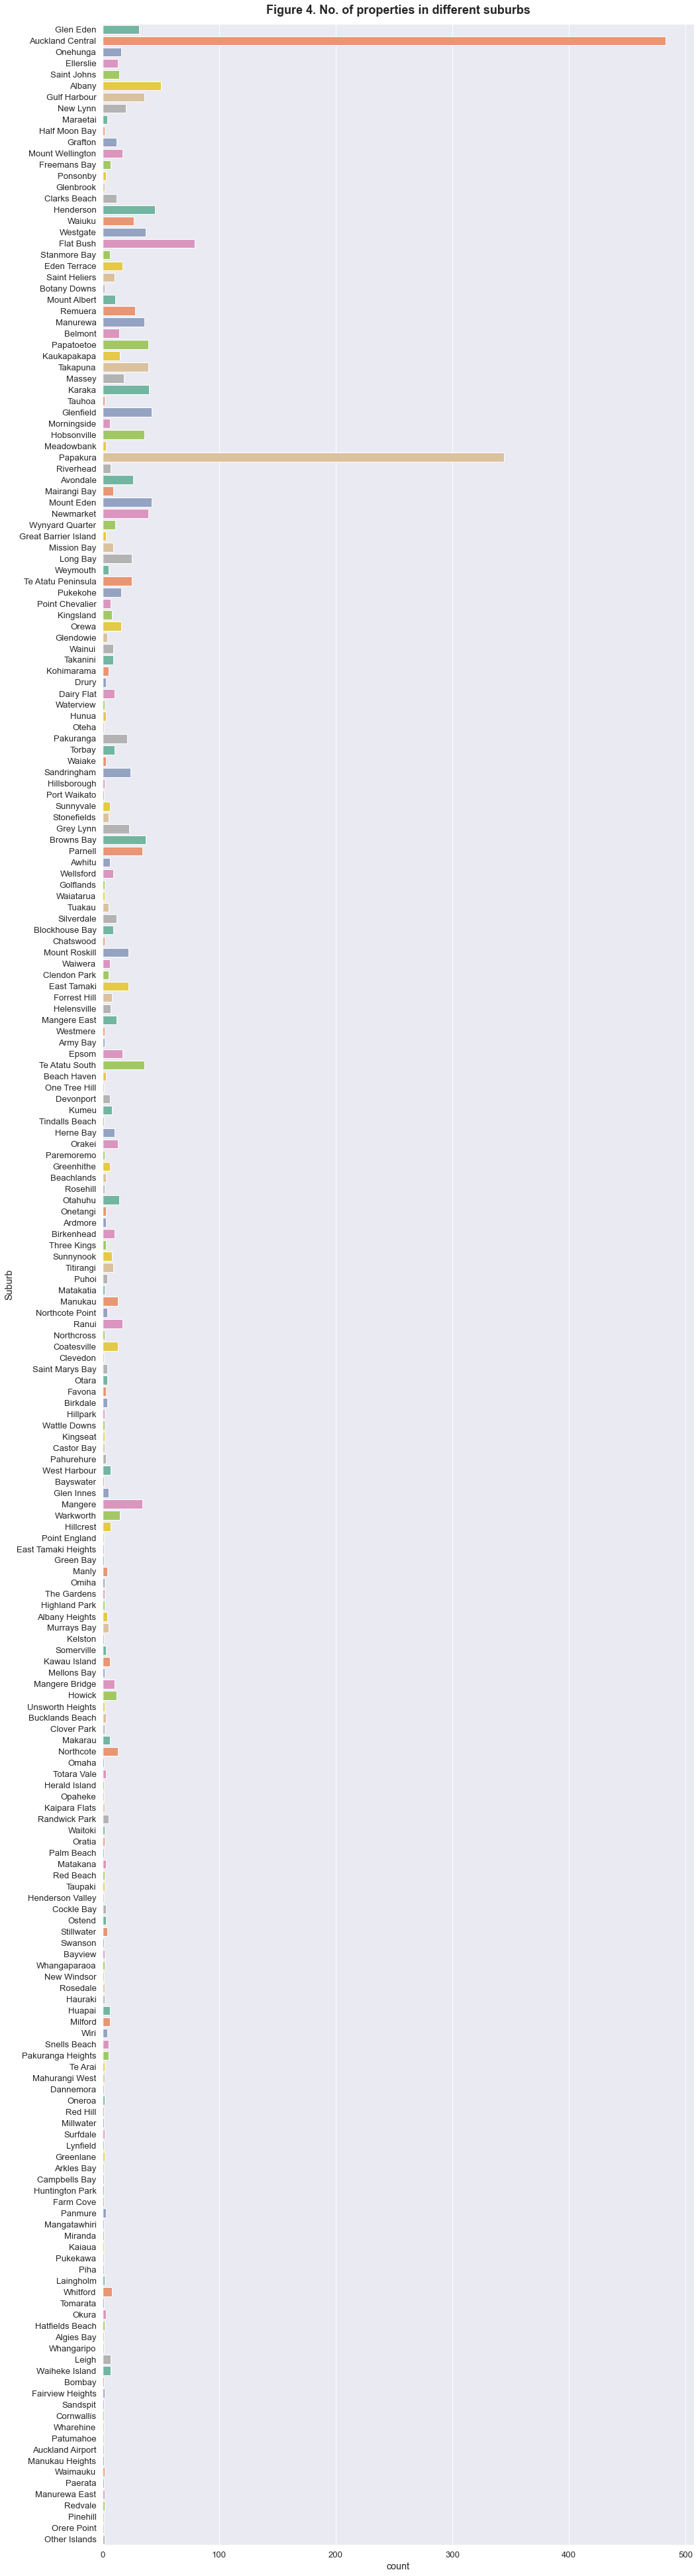

In [393]:
plt.figure(figsize=(16,70))
plt.title('Figure 4. No. of properties in different suburbs', fontsize=18, fontweight='bold', pad=15)
sns.countplot(data=df, y='Suburb', palette='Set2')

### 4.2.2 Median price by area

Figure 5 shows the median sale price and median unit price, respectively, by area. From the left-hand-side graph, we can see that properties in North Shore city have the highest median sale price at around $\$$1,200,000, and those in Central and Southern Auckland have the lowest median sale price at about $\$$750,000.

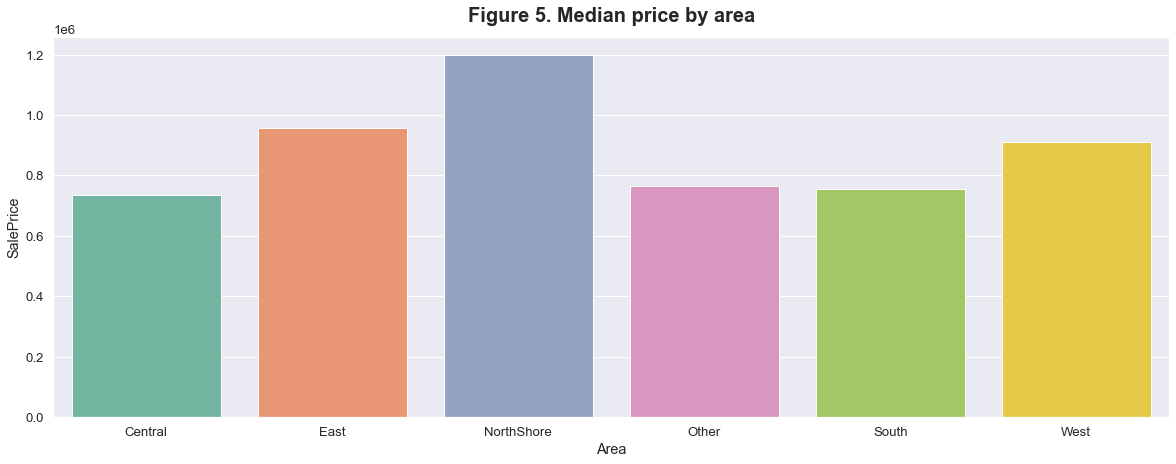

In [394]:
grouped_area = df.groupby(['Area']).median().reset_index()

plt.figure(figsize=(20,7))
plt.title('Figure 5. Median price by area', fontsize=20, fontweight='bold', pad=15)
sns.barplot(data=grouped_area, x='Area', y='SalePrice', palette='Set2')

### 4.2.3 Top 10 *vs* Bottom 10 suburbs by median price

I rank the top 10 and bottom 10 suburbs by median sale price and concatenate them into a single dataframe. As shown in Figure 6, properties on "Other Islands" currently have the highest median price at around $\$$50,000,000, whereas those on Great Barrier Island have the lowest median price at about $\$$1,000,000.

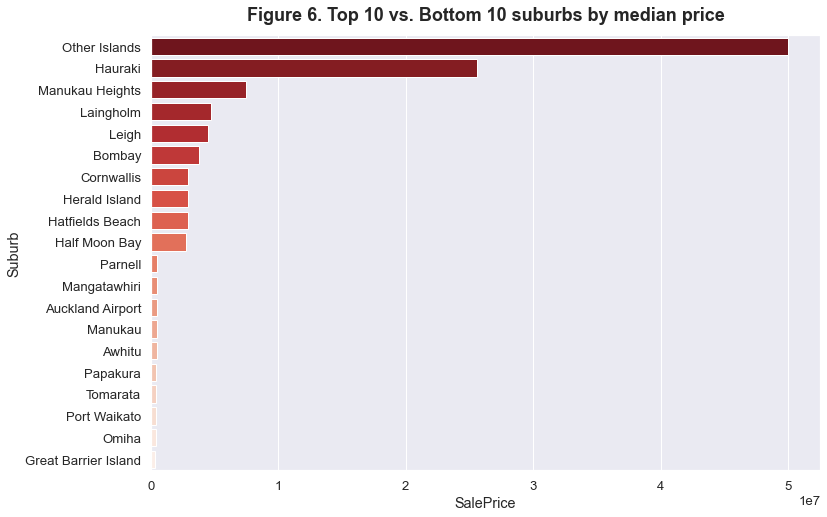

In [497]:
top10 = df.groupby(['Suburb']).median().nlargest(10, columns='SalePrice').reset_index()
bottom10 = df.groupby(['Suburb']).median().nsmallest(10, columns='SalePrice').sort_values(by='SalePrice', ascending=False).reset_index()
combined = pd.concat([top10, bottom10])

plt.figure(figsize=(12,8))
plt.title('Figure 6. Top 10 vs. Bottom 10 suburbs by median price', fontsize=18, fontweight='bold', pad=15)
sns.barplot(data=combined, x='SalePrice', y='Suburb', palette='Reds_r')

### 4.3 Property type features

### 4.3.1 Count of different property types in each area

Figure 7 shows the number of different property types in each area. Houses are the dominant type of property across all areas except Central Auckland and the "Other" area. Apartments are the dominant type in Central Auckland, while the "Other" area has more sections than the others. Moreover, townhouses are mainly for sale in western Auckland. Lifestyle properties are currently only listed in the "Other" area.

Text(0.5, 1.0, 'Figure 7. Count of property types in each area')

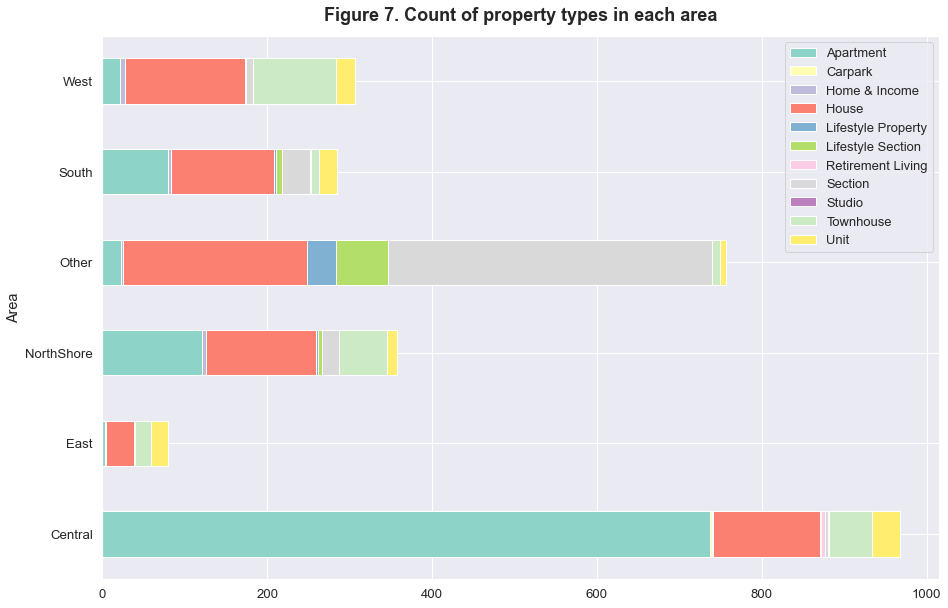

In [421]:
count_type_area = pd.crosstab(index=df['Area'], columns=df['PropertyType'])

count_type_area.plot(kind='barh', stacked=True, figsize=(15,10), cmap='Set3').legend(loc='upper right', fontsize=13)
plt.title('Figure 7. Count of property types in each area', fontsize=18, fontweight='bold', pad=15)

### 4.3.2 Median price and property types, by area

When we look at the median price of different property types in each area (Figure 8), we can see that their patterns are relatively stable across areas. The median price of lifestyle property is generally the highest, followed by home & income and section. The median price of a house ranks the middle among all.

However, the median price of lifestyle property in Central Auckland is distinctly high, which is unusual. When selecting the corresponding row from the dataframe as shown below the bar plot, I found that Pakatoa Island is categorised under Auckland Central. The two rows are partially duplicate. This is why the median price of lifestyle property in Central Auckland is significantly high.

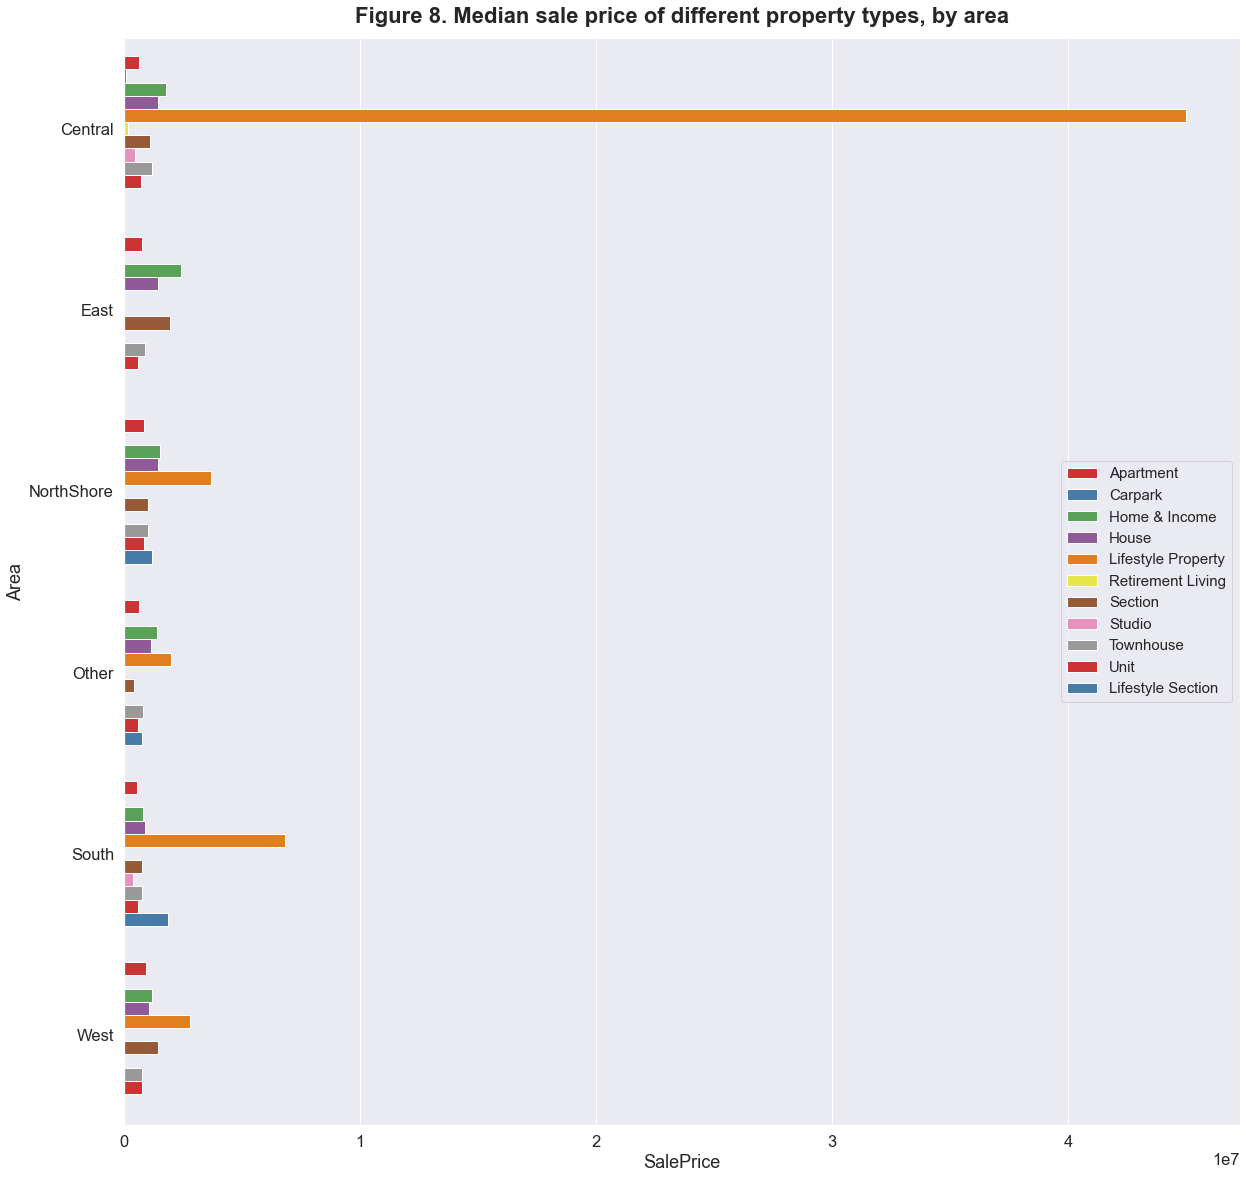

In [493]:
pivot1 = pd.pivot_table(df, index=['Area','PropertyType'], values='SalePrice', aggfunc='median').reset_index()

plt.figure(figsize=(20,20))
plt.title('Figure 8. Median sale price of different property types, by area', fontsize=22, fontweight='bold', pad=15)
sns.barplot(data=pivot1, x='SalePrice', y='Area', hue='PropertyType', palette='Set1').legend(loc='center right', fontsize=15)
sns.set(font_scale=1.6)

In [436]:
df.loc[df['PropertyType'] == 'Lifestyle Property'].loc[df['Area'] == 'Central']

,Location,Suburb,Area,Bedroom,Bathroom,LandSize_m2,PropertyType,SalePrice,Latitude,Longitude,geometry
140,"Pakatoa Island, Auckland Central",Auckland Central,Central,2,2,241000.0,Lifestyle Property,50000000,-36.81462,174.88086,POINT (174.88086 -36.81462)
2748,". Pakatoa Island, Auckland Central",Auckland Central,Central,62,62,241000.0,Lifestyle Property,40000000,-36.81462,174.88086,POINT (174.88086 -36.81462)


### 4.4 Room features

### 4.4.1 Variation in rooms

Figure 9 suggests that properties in Auckland tend to have 2 bedrooms and 1 to 2 bathrooms. We can also see that the maximum number of bedrooms and bathrooms can rise as high as 62 in Auckland's properties.

Text(0.5, 1.0, 'No. of Bathrooms')

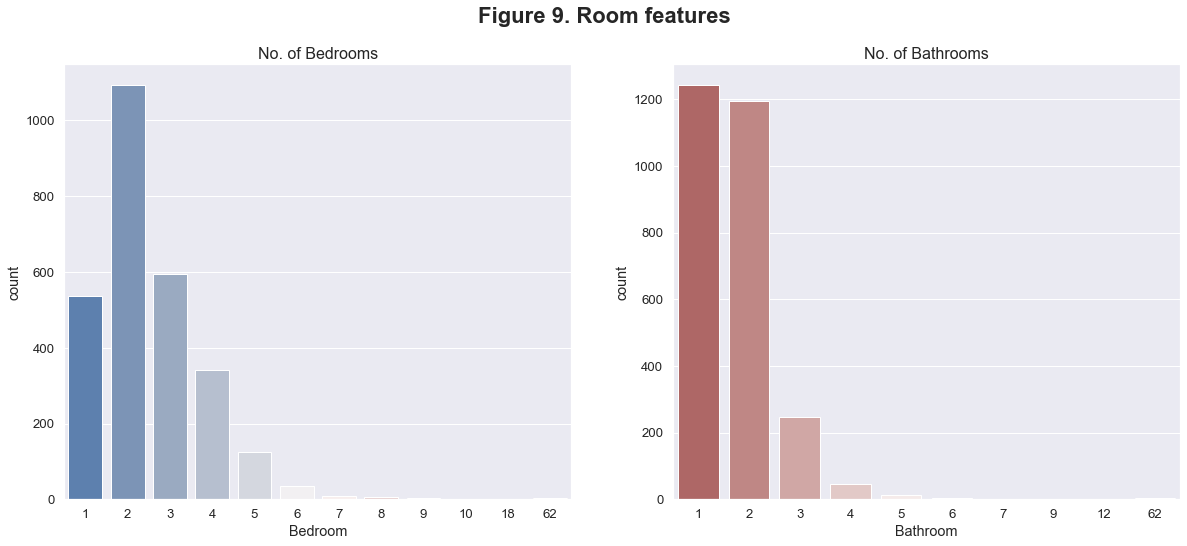

In [437]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
fig.suptitle('Figure 9. Room features', fontsize=22, fontweight='bold')

sns.countplot(data=df, x='Bedroom', ax=ax[0], palette='vlag').set_title('No. of Bedrooms', fontsize=16)
sns.countplot(data=df, x='Bathroom', ax=ax[1], palette='vlag_r').set_title('No. of Bathrooms', fontsize=16)

### 4.4.2 Median price and rooms

The patterns of relationships between the median sale price and room features are not variable for the "Bedroom" and "Bathroom" variables. Price tends to increase as the number of rooms increases. Although there are a few rare cases that should either be outliers or the only case belong to the reference group.

Text(0.5, 1.0, 'Median price vs No. of Bathrooms')

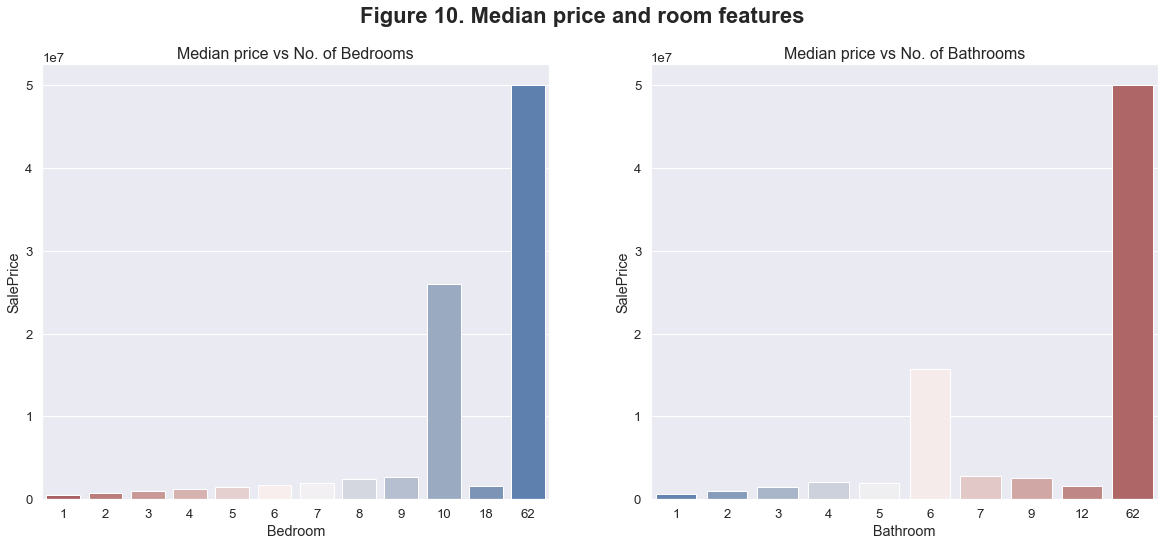

In [462]:
grouped_bed = df.groupby(['Bedroom']).median().reset_index()
grouped_bath = df.groupby(['Bathroom']).median().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(20,8))
fig.suptitle('Figure 10. Median price and room features', fontsize=22, fontweight='bold')

sns.barplot(data=grouped_bed, x='Bedroom', y='SalePrice', ax=ax[0], palette='vlag_r').set_title('Median price vs No. of Bedrooms', fontsize=16)
sns.barplot(data=grouped_bath, x='Bathroom', y='SalePrice', ax=ax[1], palette='vlag').set_title('Median price vs No. of Bathrooms', fontsize=16)

### Reference

GeoDatafram plotting, from https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391

Auckland shape file, from https://catalogue.data.govt.nz/dataset/base-region1/resource/da39e195-29d5-4bf3-9022-96ab1d476087

Auckland boundaries, from https://www.nzta.govt.nz/vehicles/regional-fuel-tax/regional-fuel-tax-information/auckland-region-maps/

```scheme=''```, from https://gis.stackexchange.com/questions/174355/altering-legend-labels-in-matplotlib

```legend_kwds={'bbox_to_anchor': (1.4, 1)}```, from https://gis.stackexchange.com/questions/371979/overlapping-legend-how-to-put-geopandas-legend-next-to-the-map

### Conclusion

Overall, this study has analysed how Auckland's current real estate market looks like based on recent property listings. The findings suggest that the median property price decreases as the properties are further away from Auckland Central. Coastal properties tend to have higher median prices than those in inland areas. Properties in Noth Shore city are more expensive than those in other areas. Concerning suburbs, islands and rural areas have higher median sale prices and have more lifestyle property, section, and lifestyle section. There is not much variation in the number of bedrooms and bathrooms by median price.